## Libraries

In [1]:
!pip install -U segmentation-models --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 265.9 MB/s eta 0:00:00


In [2]:
!pip install -U efficientnet

  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.0.0
    Uninstalling efficientnet-1.0.0:
      Successfully uninstalled efficientnet-1.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
segmentation-models 1.0.1 requires efficientnet==1.0.0, but you have efficientnet 1.1.1 which is incompatible.


## Data loading

In [3]:
import zipfile
import os

zip_path = '/content/segmentation.zip'
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete.")


Extraction complete.


In [4]:
image_dir = '/content/segmentation/original'
mask_dir = '/content/segmentation/masked'

image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)

# Count files
num_original = len([f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))])
num_masked = len([f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))])

print(f"Number of original images: {num_original}")
print(f"Number of masked images: {num_masked}")

Number of original images: 1696
Number of masked images: 1696


## Data preprocessing & training splitting

In [5]:
import os
import random
import shutil

# Output base for splits
split_base = '/content/segmentation/split_data'
splits = ['train', 'val', 'test']

# Clean existing split directories before creating new ones
for split in splits:
    split_images_dir = os.path.join(split_base, split, 'images')
    split_masks_dir = os.path.join(split_base, split, 'masks')

    # Remove existing directories
    shutil.rmtree(split_images_dir, ignore_errors=True)
    shutil.rmtree(split_masks_dir, ignore_errors=True)

    # Create fresh directories
    os.makedirs(split_images_dir, exist_ok=True)
    os.makedirs(split_masks_dir, exist_ok=True)

# Get and shuffle filenames
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]  # Filter image files
random.shuffle(image_files)

# Split proportions
n_total = len(image_files)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)

# Verify splits sum to total
assert n_train + n_val + (n_total - n_train - n_val) == n_total, "Split sizes don't add up"

split_data = {
    'train': image_files[:n_train],
    'val': image_files[n_train:n_train + n_val],
    'test': image_files[n_train + n_val:]
}

# Copy files with validation
for split, file_list in split_data.items():
    copied_count = 0
    for filename in file_list:
        src_img = os.path.join(image_dir, filename)
        src_mask = os.path.join(mask_dir, filename)

        if not os.path.exists(src_img):
            print(f"Missing image: {src_img}")
            continue

        if not os.path.exists(src_mask):
            print(f"Missing mask: {src_mask}")
            continue

        dst_img = os.path.join(split_base, split, 'images', filename)
        dst_mask = os.path.join(split_base, split, 'masks', filename)

        shutil.copy(src_img, dst_img)
        shutil.copy(src_mask, dst_mask)
        copied_count += 1

    print(f"Copied {copied_count} files to {split} set")

# Verify counts
total_copied = 0
for split in splits:
    split_images = os.listdir(os.path.join(split_base, split, 'images'))
    split_masks = os.listdir(os.path.join(split_base, split, 'masks'))

    # Ensure image-mask correspondence
    assert len(split_images) == len(split_masks), f"Mismatch in {split} set"
    assert set(split_images) == set(split_masks), "Filename mismatch in images/masks"

    print(f"Final count in {split}: {len(split_images)} images")
    total_copied += len(split_images)

# Final validation
assert total_copied == n_total, f"Total copied ({total_copied}) doesn't match original ({n_total})"
print("\n Dataset successfully split with verified counts:")
print(f"Total images: {n_total}")
print(f"Train: {len(split_data['train'])}")
print(f"Validation: {len(split_data['val'])}")
print(f"Test: {len(split_data['test'])}")
# no. of images in each folder
for split in splits:
    num_images = len(os.listdir(os.path.join(split_base, split, 'images')))
    print(f"Number of images in {split} set: {num_images}")

Copied 1356 files to train set
Copied 169 files to val set
Copied 171 files to test set
Final count in train: 1356 images
Final count in val: 169 images
Final count in test: 171 images

 Dataset successfully split with verified counts:
Total images: 1696
Train: 1356
Validation: 169
Test: 171
Number of images in train set: 1356
Number of images in val set: 169
Number of images in test set: 171


In [7]:
import numpy as np
import cv2
import tensorflow as tf
import os
from tensorflow.keras.utils import Sequence

IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 8

def load_image(path, is_mask=False):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST if is_mask else cv2.INTER_LINEAR)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)
    if is_mask:
        img = (img > 0.5).astype(np.float32)
    return img

def load_dataset(image_dir, mask_dir):
    images, masks = [], []
    file_names = sorted(os.listdir(image_dir))
    for f in file_names:
        img = load_image(os.path.join(image_dir, f), is_mask=False)
        mask = load_image(os.path.join(mask_dir, f), is_mask=True)
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

base_path = '/content/segmentation/split_data'

X_train, y_train = load_dataset(os.path.join(base_path, 'train/images'), os.path.join(base_path, 'train/masks'))
X_val, y_val     = load_dataset(os.path.join(base_path, 'val/images'), os.path.join(base_path, 'val/masks'))
X_test, y_test   = load_dataset(os.path.join(base_path, 'test/images'), os.path.join(base_path, 'test/masks'))


## Model architecture

## Using UNet Architecture

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, Model


# ========= Advanced UNet with BatchNorm & Dropout =========
def Conv2dBlock(inputTensor, numFilters, kernelSize=3, doBatchNorm=True):
    x = layers.Conv2D(filters=numFilters, kernel_size=(kernelSize, kernelSize),
                      kernel_initializer='he_normal', padding='same')(inputTensor)
    if doBatchNorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters=numFilters, kernel_size=(kernelSize, kernelSize),
                      kernel_initializer='he_normal', padding='same')(x)
    if doBatchNorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def GiveMeUnet(inputImage, numFilters=16, droupouts=0.3, doBatchNorm=True):
    c1 = Conv2dBlock(inputImage, numFilters * 1, doBatchNorm=doBatchNorm)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, doBatchNorm=doBatchNorm)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, doBatchNorm=doBatchNorm)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, doBatchNorm=doBatchNorm)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    p4 = layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, doBatchNorm=doBatchNorm)

    u6 = layers.Conv2DTranspose(numFilters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    u6 = layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, doBatchNorm=doBatchNorm)

    u7 = layers.Conv2DTranspose(numFilters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    u7 = layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, doBatchNorm=doBatchNorm)

    u8 = layers.Conv2DTranspose(numFilters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    u8 = layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, doBatchNorm=doBatchNorm)

    u9 = layers.Conv2DTranspose(numFilters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    u9 = layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, doBatchNorm=doBatchNorm)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[inputImage], outputs=[outputs])
    return model

model = GiveMeUnet(tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_5[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_68[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_63       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 256, 256,  │      2,320 │ activation_63[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_69[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_64       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ activation_64[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 128, 128,  │          0 │ max_pooling2d_8[… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 128, 128,  │      4,640 │ dropout_16[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_70[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_65       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_65[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_71[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_66       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ activation_66[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64, 64,    │          0 │ max_pooling2d_9[

 Total params: 2,164,305 (8.26 MB)

 Trainable params: 2,161,361 (8.24 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [22]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [23]:
inputs = tf.keras.layers.Input((256, 256, 1))
model = GiveMeUnet(inputs, droupouts=0.3)
def combo_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_coef(y_true, y_pred)
    return bce + (1 - dice)

model.compile(optimizer='adam', loss=combo_loss, metrics=['accuracy', dice_coef, iou_coef])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_custom_unet.h5', monitor='val_dice_coef', save_best_only=True, verbose=1, mode = 'max'),
    tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=5, restore_best_weights=True, mode='max')
]

unet_history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=8,
    callbacks=callbacks
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1749']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8685 - dice_coef: 0.4964 - iou_coef: 0.3409 - loss: 0.8561
Epoch 1: val_dice_coef improved from -inf to 0.28683, saving model to best_custom_unet.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 65s 200ms/step - accuracy: 0.8688 - dice_coef: 0.4970 - iou_coef: 0.3414 - loss: 0.8549 - val_accuracy: 0.2251 - val_dice_coef: 0.2868 - val_iou_coef: 0.1681 - val_loss: 7.4279
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9381 - dice_coef: 0.7290 - iou_coef: 0.5751 - loss: 0.4406
Epoch 2: val_dice_coef improved from 0.28683 to 0.49989, saving model to best_custom_unet.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 46s 92ms/step - accuracy: 0.9381 - dice_coef: 0.7291 - iou_coef: 0.5753 - loss: 0.4404 - val_accuracy: 0.7084 - val_dice_coef: 0.4999 - val_iou_coef: 0.3348 - val_loss: 1.4108
Epoch 3/20
169/170 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9457 - dice_coef: 0.7806 - iou_coef: 0.6415 - loss: 0.3656
Epoch 3: val_dice_coef improved from 0.49989 to 0.62881, saving model to best_custom_unet.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.9457 - dice_coef: 0.7806 - iou_coef: 0.6415 - loss: 0.3656 - val_accuracy: 0.8262 - val_dice_coef: 0.6288 - val_iou_coef: 0.4626 - val_loss: 1.1025
Epoch 4/20
169/170 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9471 - dice_coef: 0.7941 - iou_coef: 0.6597 - loss: 0.3493
Epoch 4: val_dice_coef improved from 0.62881 to 0.78292, saving model to best_custom_unet.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9471 - dice_coef: 0.7941 - iou_coef: 0.6598 - loss: 0.3492 - val_accuracy: 0.9273 - val_dice_coef: 0.7829 - val_iou_coef: 0.6456 - val_loss: 0.5031
Epoch 5/20
169/170 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9502 - dice_coef: 0.8056 - iou_coef: 0.6763 - loss: 0.3309
Epoch 5: val_dice_coef improved from 0.78292 to 0.81676, saving model to best_custom_unet.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.9502 - dice_coef: 0.8056 - iou_coef: 0.6763 - loss: 0.3309 - val_accuracy: 0.9485 - val_dice_coef: 0.8168 - val_iou_coef: 0.6921 - val_loss: 0.3396
Epoch 6/20
169/170 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9542 - dice_coef: 0.8194 - iou_coef: 0.6949 - loss: 0.3056
Epoch 6: val_dice_coef did not improve from 0.81676
170/170 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.9542 - dice_coef: 0.8193 - iou_coef: 0.6949 - loss: 0.3057 - val_accuracy: 0.9320 - val_dice_coef: 0.7815 - val_iou_coef: 0.6438 - val_loss: 0.4051
Epoch 7/20
169/170 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9541 - dice_coef: 0.8232 - iou_coef: 0.7005 - loss: 0.3027
Epoch 7: val_dice_coef did not improve from 0.81676
170/170 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.9541 - dice_coef: 0.8232 - iou_coef: 0.7005 - loss: 0.3028 - val_accuracy: 0.9451 - val_dice_coef: 0.7821 - val_iou_coef: 0.6441 - val_loss: 0.3900
Epoch 8/20
169/170 ━━━━━━━━━━

170/170 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.9562 - dice_coef: 0.8302 - iou_coef: 0.7111 - loss: 0.2892 - val_accuracy: 0.9498 - val_dice_coef: 0.8171 - val_iou_coef: 0.6918 - val_loss: 0.3373
Epoch 9/20
169/170 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9570 - dice_coef: 0.8334 - iou_coef: 0.7158 - loss: 0.2839
Epoch 9: val_dice_coef did not improve from 0.81706
170/170 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.9570 - dice_coef: 0.8334 - iou_coef: 0.7158 - loss: 0.2840 - val_accuracy: 0.8890 - val_dice_coef: 0.4398 - val_iou_coef: 0.2900 - val_loss: 0.9465
Epoch 10/20
169/170 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9559 - dice_coef: 0.8307 - iou_coef: 0.7115 - loss: 0.2904
Epoch 10: val_dice_coef improved from 0.81706 to 0.83127, saving model to best_custom_unet.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.9559 - dice_coef: 0.8307 - iou_coef: 0.7115 - loss: 0.2904 - val_accuracy: 0.9538 - val_dice_coef: 0.8313 - val_iou_coef: 0.7130 - val_loss: 0.3233
Epoch 11/20
169/170 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9568 - dice_coef: 0.8348 - iou_coef: 0.7179 - loss: 0.2855
Epoch 11: val_dice_coef did not improve from 0.83127
170/170 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.9568 - dice_coef: 0.8348 - iou_coef: 0.7180 - loss: 0.2854 - val_accuracy: 0.9299 - val_dice_coef: 0.7822 - val_iou_coef: 0.6456 - val_loss: 0.4347
Epoch 12/20
169/170 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9570 - dice_coef: 0.8362 - iou_coef: 0.7201 - loss: 0.2826
Epoch 12: val_dice_coef did not improve from 0.83127
170/170 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.9571 - dice_coef: 0.8363 - iou_coef: 0.7201 - loss: 0.2825 - val_accuracy: 0.9428 - val_dice_coef: 0.7608 - val_iou_coef: 0.6155 - val_loss: 0.4155
Epoch 13/20
169/170 ━━━━━

In [36]:
best_model = tf.keras.models.load_model('best_custom_unet.h5', custom_objects={'combo_loss':combo_loss, 'dice_coef': dice_coef, 'iou_coef': iou_coef})
test_loss_unet, test_acc_unet, test_dice_unet, test_iou_unet = best_model.evaluate(X_test, y_test, verbose=0)
print(f" Test Accuracy: {test_acc_unet:.4f}")
print(f" Test Dice Coefficient: {test_dice_unet:.4f}")
print(f" Test IoU Score: {test_iou_unet:.4f}")



 Test Accuracy: 0.9566
 Test Dice Coefficient: 0.8402
 Test IoU Score: 0.7246


## Using DeepLabV3+ model:

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

def ASPP(x, num_filters):
    shape = x.shape
    y1 = layers.Conv2D(num_filters, 1, padding="same", use_bias=False)(x)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.Activation("relu")(y1)

    y2 = layers.Conv2D(num_filters, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.Activation("relu")(y2)

    y3 = layers.Conv2D(num_filters, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y3 = layers.BatchNormalization()(y3)
    y3 = layers.Activation("relu")(y3)

    y4 = layers.Conv2D(num_filters, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y4 = layers.BatchNormalization()(y4)
    y4 = layers.Activation("relu")(y4)

    y5 = layers.GlobalAveragePooling2D()(x)
    y5 = layers.Reshape((1, 1, shape[-1]))(y5)
    y5 = layers.Conv2D(num_filters, 1, padding="same", use_bias=False)(y5)
    y5 = layers.BatchNormalization()(y5)
    y5 = layers.Activation("relu")(y5)
    y5 = layers.UpSampling2D(size=(shape[1], shape[2]), interpolation="bilinear")(y5)

    y = layers.Concatenate()([y1, y2, y3, y4, y5])
    y = layers.Conv2D(num_filters, 1, padding="same", use_bias=False)(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation("relu")(y)

    return y

def DeepLabV3Plus(input_shape=(256, 256, 1), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # If grayscale, repeat channels to make 3
    x = layers.Concatenate()([inputs, inputs, inputs])

    base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=x)

    image_features = base_model.get_layer("conv4_block6_2_relu").output
    x_a = ASPP(image_features, 256)

    low_level_features = base_model.get_layer("conv2_block3_2_relu").output
    low_level_features = layers.Conv2D(48, 1, padding="same", use_bias=False)(low_level_features)
    low_level_features = layers.BatchNormalization()(low_level_features)
    low_level_features = layers.Activation("relu")(low_level_features)

    x_a = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x_a)
    x = layers.Concatenate()([x_a, low_level_features])

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    x = layers.Conv2D(num_classes, 1, padding="same", activation="sigmoid")(x)

    return models.Model(inputs=inputs, outputs=x)

# model.summary()

In [26]:
# Build model
deeplab_model = DeepLabV3Plus(input_shape=(256, 256, 1))

# Use same combo loss (Dice + BCE)
def dice_bce_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_coef(y_true, y_pred)
    return bce + (1 - dice)

deeplab_model.compile(
    optimizer='adam',
    loss=dice_bce_loss,
    metrics=['accuracy', dice_coef, iou_coef]
)

# Train
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_deeplabv3.h5', monitor='val_dice_coef', save_best_only=True, mode='max', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=5, restore_best_weights=True, mode='max')
]

deeplab_history = deeplab_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=8,
    callbacks=callbacks
)


Epoch 1/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9228 - dice_coef: 0.7316 - iou_coef: 0.5918 - loss: 0.4831
Epoch 1: val_dice_coef improved from -inf to 0.48235, saving model to best_deeplabv3.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 128s 448ms/step - accuracy: 0.9229 - dice_coef: 0.7320 - iou_coef: 0.5922 - loss: 0.4824 - val_accuracy: 0.8943 - val_dice_coef: 0.4824 - val_iou_coef: 0.3192 - val_loss: 0.8903
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9579 - dice_coef: 0.8377 - iou_coef: 0.7220 - loss: 0.2781
Epoch 2: val_dice_coef improved from 0.48235 to 0.54394, saving model to best_deeplabv3.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 92s 274ms/step - accuracy: 0.9579 - dice_coef: 0.8377 - iou_coef: 0.7220 - loss: 0.2781 - val_accuracy: 0.9113 - val_dice_coef: 0.5439 - val_iou_coef: 0.3741 - val_loss: 0.6800
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9586 - dice_coef: 0.8410 - iou_coef: 0.7269 - loss: 0.2711
Epoch 3: val_dice_coef did not improve from 0.54394
170/170 ━━━━━━━━━━━━━━━━━━━━ 80s 266ms/step - accuracy: 0.9586 - dice_coef: 0.8410 - iou_coef: 0.7269 - loss: 0.2711 - val_accuracy: 0.8421 - val_dice_coef: 0.1100 - val_iou_coef: 0.0583 - val_loss: 1.4663
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9601 - dice_coef: 0.8470 - iou_coef: 0.7355 - loss: 0.2585
Epoch 4: val_dice_coef did not improve from 0.54394
170/170 ━━━━━━━━━━━━━━━━━━━━ 83s 270ms/step - accuracy: 0.9601 - dice_coef: 0.8470 - iou_coef: 0.7355 - loss: 0.2585 - val_accuracy: 0.8425 - val_dice_coef: 0.0529 - val_iou_coef: 0.0272 - val_loss: 1.6498
Epoch 5/20
170/170 ━━━━━

170/170 ━━━━━━━━━━━━━━━━━━━━ 84s 276ms/step - accuracy: 0.9642 - dice_coef: 0.8626 - iou_coef: 0.7591 - loss: 0.2321 - val_accuracy: 0.9381 - val_dice_coef: 0.7463 - val_iou_coef: 0.5965 - val_loss: 0.4672
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9652 - dice_coef: 0.8674 - iou_coef: 0.7667 - loss: 0.2260
Epoch 7: val_dice_coef improved from 0.74631 to 0.80728, saving model to best_deeplabv3.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 275ms/step - accuracy: 0.9653 - dice_coef: 0.8674 - iou_coef: 0.7667 - loss: 0.2260 - val_accuracy: 0.9471 - val_dice_coef: 0.8073 - val_iou_coef: 0.6791 - val_loss: 0.3279
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9665 - dice_coef: 0.8720 - iou_coef: 0.7738 - loss: 0.2165
Epoch 8: val_dice_coef did not improve from 0.80728
170/170 ━━━━━━━━━━━━━━━━━━━━ 80s 266ms/step - accuracy: 0.9665 - dice_coef: 0.8720 - iou_coef: 0.7738 - loss: 0.2166 - val_accuracy: 0.8585 - val_dice_coef: 0.2296 - val_iou_coef: 0.1324 - val_loss: 1.4107
Epoch 9/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9675 - dice_coef: 0.8759 - iou_coef: 0.7797 - loss: 0.2097
Epoch 9: val_dice_coef did not improve from 0.80728
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 265ms/step - accuracy: 0.9675 - dice_coef: 0.8759 - iou_coef: 0.7797 - loss: 0.2097 - val_accuracy: 0.8766 - val_dice_coef: 0.3986 - val_iou_coef: 0.2541 - val_loss: 1.0962
Epoch 10/20
170/170 ━━━━

In [37]:
best_model = tf.keras.models.load_model('best_deeplabv3.h5', custom_objects={'dice_coef': dice_coef, 'iou_coef': iou_coef, 'dice_bce_loss': dice_bce_loss})
test_loss_deeplab, test_acc_deeplab, test_dice_deeplab, test_iou_deeplab = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc_deeplab:.4f}")
print(f"Test Dice Coefficient: {test_dice_deeplab:.4f}")
print(f"Test IoU Score: {test_iou_deeplab:.4f}")


Test Accuracy: 0.9527
Test Dice Coefficient: 0.8294
Test IoU Score: 0.7087


## Evaluation metrics

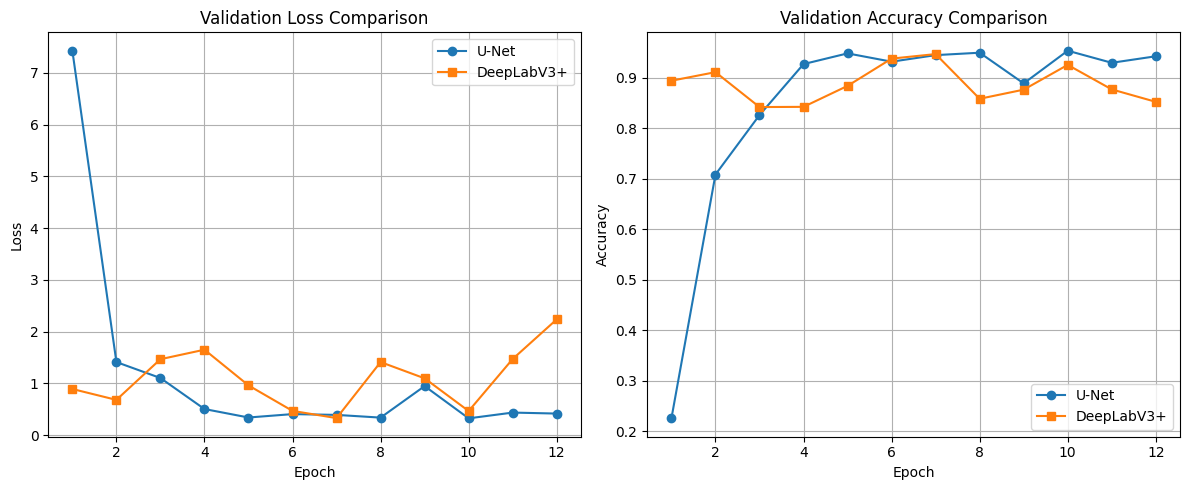

In [40]:
import matplotlib.pyplot as plt


min_epochs = min(len(unet_history.history['val_loss']), len(deeplab_history.history['val_loss']))
epochs = range(1, min_epochs + 1)

# Plot training & validation loss
plt.figure(figsize=(12, 5))

# Validation Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, unet_history.history['val_loss'][:min_epochs], label='U-Net', marker='o')
plt.plot(epochs, deeplab_history.history['val_loss'][:min_epochs], label='DeepLabV3+', marker='s')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Validation Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, unet_history.history['val_accuracy'][:min_epochs], label='U-Net', marker='o')
plt.plot(epochs, deeplab_history.history['val_accuracy'][:min_epochs], label='DeepLabV3+', marker='s')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


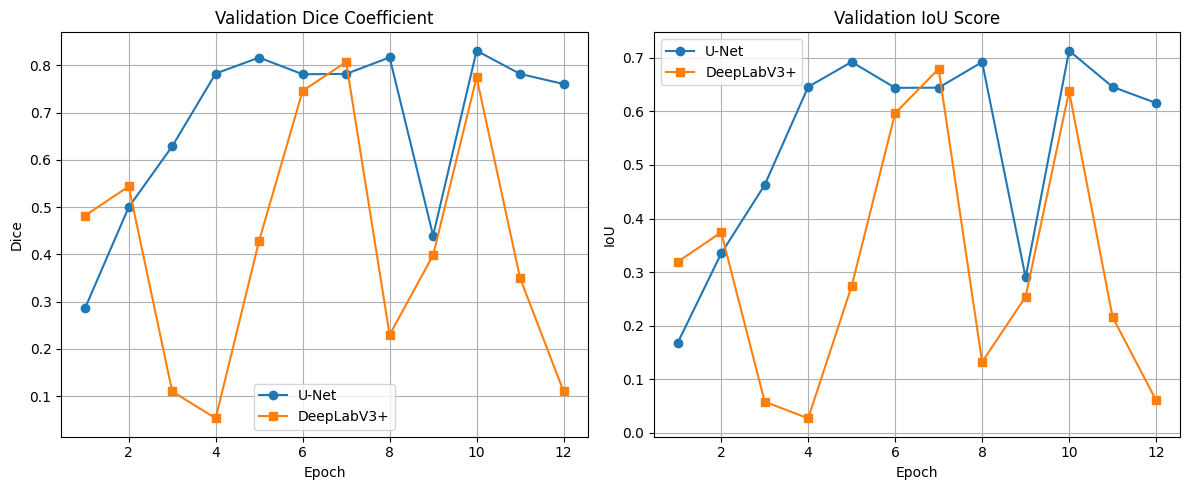

In [41]:
import matplotlib.pyplot as plt

# Define epoch range
min_epochs = min(len(unet_history.history['val_loss']), len(deeplab_history.history['val_loss']))
epochs = range(1, min_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Dice Coefficient
plt.subplot(1, 2, 1)
plt.plot(epochs, unet_history.history['val_dice_coef'][:min_epochs], label='U-Net', marker='o')
plt.plot(epochs, deeplab_history.history['val_dice_coef'][:min_epochs], label='DeepLabV3+', marker='s')
plt.title('Validation Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)

# Plot IoU Score
plt.subplot(1, 2, 2)
plt.plot(epochs, unet_history.history['val_iou_coef'][:min_epochs], label='U-Net', marker='o')
plt.plot(epochs, deeplab_history.history['val_iou_coef'][:min_epochs], label='DeepLabV3+', marker='s')
plt.title('Validation IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

# Save and display
plt.tight_layout()
plt.show()


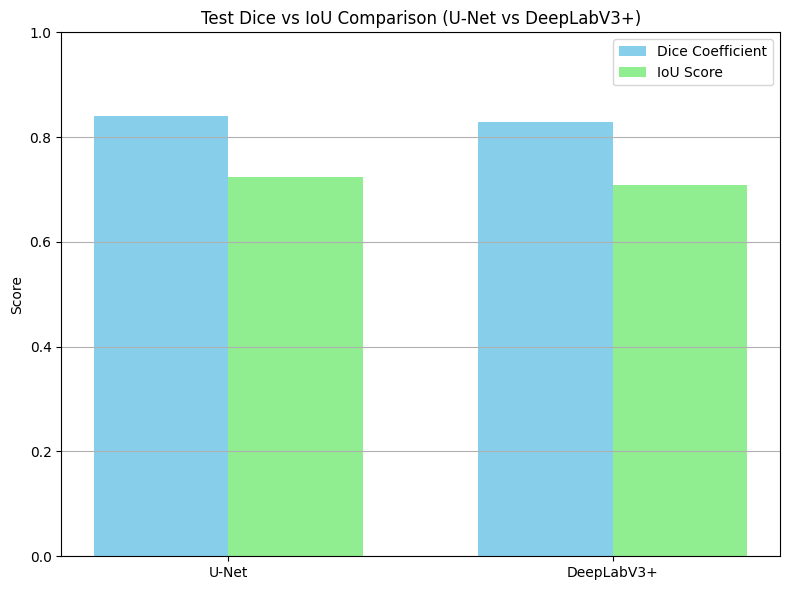

In [42]:
import matplotlib.pyplot as plt


# Organize into lists
models = ['U-Net', 'DeepLabV3+']
dice_scores = [test_dice_unet, test_dice_deeplab]
iou_scores = [test_iou_unet, test_iou_deeplab]

# Plotting
x = range(len(models))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar([i - width/2 for i in x], dice_scores, width=width, label='Dice Coefficient', color='skyblue')
plt.bar([i + width/2 for i in x], iou_scores, width=width, label='IoU Score', color='lightgreen')

plt.xticks(ticks=x, labels=models)
plt.ylabel("Score")
plt.title("Test Dice vs IoU Comparison (U-Net vs DeepLabV3+)")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y')

# Save plot
plt.tight_layout()
plt.show()
